# METR 3123 HW \#3

## Due Monday March 21 at 9 PM.

This is the jupyter notebook for our 3rd homework assignment

Jupyter is a web-based interactive coding framework. Many scientists use jupyter notebooks as their primary research platform, because its block formatting caters very well to debugging, while blocks can be a mix between text (like this), code, and figures to make the project into more of a narrative. Most notebooks heavily use python, which is what we'll use.

You are viewing this jupyter notebook through a Binder, which creates your own personal copy of our [class Github repository](https://github.com/jhruppert/OU-Dynamics-3123). ***SAVE YOUR BINER URL IN ORDER TO RETURN TO YOUR WORK.*** What you modify here will not change our class github repository, though you can return to your work at a later time provided you keep and use the same Binder URL.

---

This cell loads up necessary packages:

In [21]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy

Our case for analysis is [Hurricane Sandy](https://en.wikipedia.org/wiki/Hurricane_Sandy), which provides a phenomenally strong large-scale upper-level trough/ridge pattern, strong ageostrophic and vertical motion, all coupled to the landfalling warm core Hurricane Sandy.

Our data is provided in the form of 7 netcdf files.

The below command lists the data directory contents:

In [36]:
!ls data/sandy/

ERA5-sandy-pl_100.nc  ERA5-sandy-pl_300.nc  ERA5-sandy-pl_850.nc
ERA5-sandy-pl_1000.nc ERA5-sandy-pl_500.nc
ERA5-sandy-pl_200.nc  ERA5-sandy-pl_700.nc


Each file is a separate pressure level (the numbers in the filename are hPa), containing the following:
- 16 time steps (dt = 6 h), starting at 0000 UTC 27 Oct 2012
- With the variables:
    - "u" - zonal wind (m/s)
    - "v" - meridional ...
    - "w" - vertical ...
    - "t" - temperature (K)
    - "z" - geopotential ($m^2/s^2$)

In the below blocks there are variables that you need to set to select the desired pressure level and time step to plot.

In [23]:
pressure = '300' # select the pressure level
nc = Dataset('data/sandy/ERA5-sandy-pl_'+pressure+'.nc') # this opens the netcdf file

In [48]:
itime = 13 # choose index of time

# read the horizontal wind components
u = nc.variables['u'][itime, :, :] # result is 2d array (lat, lon), m/s
v = nc.variables['v'][itime, :, :]
# wind speed in m/s
spd = np.sqrt(u**2 + v**2)

# convert wind components from m/s --> knots for wind barb plotting
mps_to_kts=1.94384 # conversion factor
u = u * mps_to_kts
v = v * mps_to_kts

# make 2d lat, lon grid to match u, v size
lat, lon = np.meshgrid(nc.variables['latitude'][:], nc.variables['longitude'][:], indexing='ij')

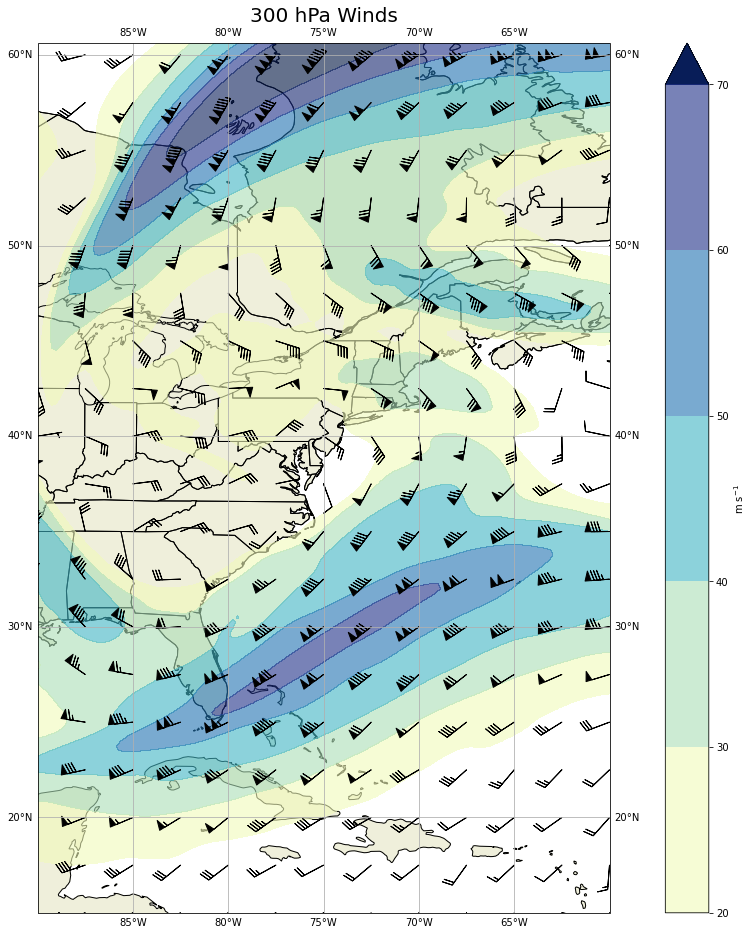

In [50]:
# select plotting area
plt_area=[-90, -60, 15, 60] # W,E,S,N

spacing=10 #barbspacing (smaller if zoomed in)

# create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

# contourf for wind speed shading
im = ax.contourf(lon, lat, spd, np.arange(20, np.nanmax(spd), 10), cmap='YlGnBu', alpha=0.6, extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')

# wind barbs
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], u[::spacing,::spacing], v[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND) #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available data)
ax.set_extent(plt_area)

plt.show()